In [ ]:
%load_ext autoreload
import race
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
import optuna
%matplotlib inline

In [ ]:
#import gymnasium
#from gymnasium import spaces
#import pygame
#import numpy as np
#from race import *
#
#class CurvyRaceEnv(gymnasium.Env):
#    def __init__(self):
#        super(CurvyRaceEnv, self).__init__()
#
#        # Initialize the CurvyRace environment
#        self.curvy_race = CurvyRace()
#        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
#        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
#
#    def reset(self, seed = None):
#        # Reset the CurvyRace environment
#        obs = self.curvy_race.reset()
#        # Explicitly cast the observation to float32
#        obs = np.array(obs, dtype=np.float32)
#        info = {}  # You can provide additional information here if needed
#        return obs, info
#    
#    def step(self, action):
#        # Take a step in the CurvyRace environment
#        obs, reward, done = self.curvy_race.step(action)
#        obs = np.array(obs, dtype=np.float32)
#
#        return obs, reward, done, False, {}
#
#    def render(self, mode='human'):
#        # Render the CurvyRace environment (for visualization purposes)
#        self.curvy_race.plot()
#
#    def close(self):
#        # Clean up resources, if any
#        pass

In [ ]:
from stable_baselines3.common.env_checker import check_env
import CurvyRaceEnv
test = CurvyRaceEnv.CurvyRaceEnv()
check_env(test)

In [ ]:
from gymnasium.envs.registration import register

register(
     id="CurvyRaceEnv-v0",
     entry_point="CurvyRaceEnv:CurvyRaceEnv",
     max_episode_steps=100,
)

In [ ]:
from typing import Any
from typing import Dict

import gymnasium
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

import torch
import torch.nn as nn
import time
N_TRIALS = 10000
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = 20000
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CurvyRaceEnv-v0"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}

In [ ]:
from typing import Optional

class TrialEvalCallback(EvalCallback):
    """
    Callback used for evaluating and reporting a trial.
    """

    def __init__(
            self,
            eval_env: gym.Env,
            trial: optuna.Trial,
            n_eval_episodes: int = 5,
            eval_freq: int = 10000,
            deterministic: bool = True,
            verbose: int = 0,
            best_model_save_path: Optional[str] = None,
            log_path: Optional[str] = None,
            callback_after_eval: Optional[BaseCallback] = None
    ):

        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
            best_model_save_path=best_model_save_path,
            log_path=log_path,
            callback_after_eval=callback_after_eval
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        continue_training = True
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            continue_training = super()._on_step()
            self.eval_idx += 1
            # report best or report current ?
            # report num_timesteps or elapsed time ?
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if needed
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return continue_training

In [ ]:
from typing import Dict, Any, Union, Callable
 
def sample_ppo_params(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for PPO hyperparams.
    
    :param trial:
    :return:
    """
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512, 1024])
    n_steps = trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048])
    gamma = trial.suggest_categorical("gamma", [0.5, 0.8, 0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1)
    #lr_schedule = trial.suggest_categorical('lr_schedule', ['linear', 'constant'])
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1)
    clip_range = trial.suggest_categorical("clip_range", [0.1, 0.2, 0.3, 0.4])
    n_epochs = trial.suggest_categorical("n_epochs", [1, 5, 10, 20])
    gae_lambda = trial.suggest_categorical("gae_lambda", [0.8, 0.9, 0.92, 0.95, 0.98, 0.99, 1.0])
    max_grad_norm = trial.suggest_categorical("max_grad_norm", [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5])
    vf_coef = trial.suggest_float("vf_coef", 0, 1)
    
    # Uncomment for gSDE (continuous actions)
    # log_std_init = trial.suggest_uniform("log_std_init", -4, 1)
    # Uncomment for gSDE (continuous action)
    # sde_sample_freq = trial.suggest_categorical("sde_sample_freq", [-1, 8, 16, 32, 64, 128, 256])
    # Orthogonal initialization
    ortho_init = trial.suggest_categorical('ortho_init', [False, True])
    activation_fn = trial.suggest_categorical('activation_fn', ['tanh', 'relu', 'elu', 'leaky_relu'])
    
    # TODO: account when using multiple envs
    if batch_size > n_steps:
        batch_size = n_steps
    
    #if lr_schedule == "linear":
       # learning_rate = linear_schedule(learning_rate)
    
    # Independent networks usually work best
    # when not working with images
    """
    net_arch = trial.suggest_categorical("net_arch", ["tiny", "small", "medium"])
    net_arch = {
        "tiny": [dict(pi=[8, 8], vf=[8, 8])],
        "small": [dict(pi=[64, 64], vf=[64, 64])],
        "medium": [dict(pi=[256, 256], vf=[256, 256])],
    }[net_arch]
    """
    net_arch_width = trial.suggest_categorical("net_arch_width", [8, 16, 32, 64, 128, 256, 512])
    net_arch_depth = trial.suggest_int("net_arch_depth", 1, 3)
    net_arch = [dict(pi=[net_arch_width] * net_arch_depth, vf=[net_arch_width] * net_arch_depth)]
    
    activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}[activation_fn]
    
    return {
        "n_steps": n_steps,
        "batch_size": batch_size,
        "gamma": gamma,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "clip_range": clip_range,
        "n_epochs": n_epochs,
        "gae_lambda": gae_lambda,
        "max_grad_norm": max_grad_norm,
        "vf_coef": vf_coef,
        # "sde_sample_freq": sde_sample_freq,
        "policy_kwargs": dict(
            # log_std_init=log_std_init,
            net_arch=net_arch,
            activation_fn=activation_fn,
            ortho_init=ortho_init,
        ),
    }

In [ ]:
from stable_baselines3 import A2C, PPO, TD3

def objective(trial: optuna.Trial) -> float:

    time.sleep(random.random() * 16)

    step_mul = trial.suggest_categorical("step_mul", [4, 8, 16, 32, 64])
    env_kwargs = {"step_mul": step_mul}

    sampled_hyperparams = sample_ppo_params(trial)


    env = gymnasium.make(ENV_ID)
    env = Monitor(env)
    model = PPO("MlpPolicy", env=env, seed=None, verbose=0, **sampled_hyperparams)

    stop_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=30, min_evals=50, verbose=1)
    eval_callback = TrialEvalCallback(
        env, trial, 
        n_eval_episodes=5, eval_freq=10000, deterministic=False, callback_after_eval=stop_callback
    )

    

    try:
        model.learn(10000, callback=eval_callback)
        env.close()
    except (AssertionError, ValueError) as e:
        env.close()
        print(e)
        print("============")
        print("Sampled params:")
        print(sampled_hyperparams)
        raise optuna.exceptions.TrialPruned()

    is_pruned = eval_callback.is_pruned
    reward = eval_callback.best_mean_reward

    del model.env
    del model

    if is_pruned:
        raise optuna.exceptions.TrialPruned()

    return reward

In [ ]:
#study = optuna.create_study(study_name="PPO2", storage="sqlite:///DRL2.db", load_if_exists=True, direction="maximize")
#study.optimize(objective, n_trials=N_TRIALS, n_jobs=4, timeout=600, gc_after_trial=True, show_progress_bar=True)

In [29]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DDPG, TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


env = gymnasium.make("CurvyRaceEnv-v0")


# Train the agent
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env,  learning_rate=1e-3,policy_kwargs=dict(net_arch=[400,300]), learning_starts=10000,gradient_steps=-1, gamma = 0.9, buffer_size=200000)
#model = SAC("MlpPolicy", env, verbose=1, batch_size=64, learning_rate=0.003, gamma=0.9, tau=0.05)
    
model.learn(total_timesteps=3e4, log_interval=10)
model.save("model_test2")
vec_env = model.get_env()
del model

In [31]:
def run_env(env, model):
    obs, info = env.reset()
    done = False
    reward_list = []
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, info, _ = env.step(action)
        reward_list.append(rewards)
    
    return reward_list

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_rewards(rewards):
    """
    Plots the cumulative rewards per episode.
    """
    # Calculate the cumulative sum of the list elements
    cumulative_rewards = {key: np.cumsum(value) for key, value in rewards.items()}

    # Plot the cumulative rewards
    for key, value in cumulative_rewards.items():
        plt.plot(value, label=key)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


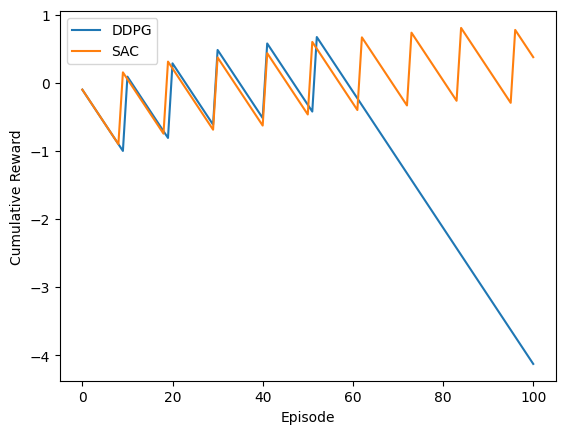

In [43]:
ddpg = DDPG.load("model_test2")
sac = SAC.load("model_test")

test = gymnasium.make("CurvyRaceEnv-v0")

rewards = {}
rewards["DDPG"] = run_env(test, ddpg)
rewards["SAC"] = run_env(test, sac)

plot_cumulative_rewards(rewards)